In [2]:
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import pywt
import math
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import csv
import scipy.signal
from scipy.signal import butter, lfilter

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

In [9]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [19]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [20]:
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

https://www.sciencedirect.com/science/article/pii/S0957417411006075

In [10]:
def wrcoef(X, coef_type, coeffs, wavename, level):
    N = np.array(X).size
    a, ds = coeffs[0], list(reversed(coeffs[1:]))

    if coef_type =='a':
        return pywt.upcoef('a', a, wavename, level=level,take=N)[:N]
    elif coef_type == 'd':
        return pywt.upcoef('d', ds[level-1], wavename, level=level,take=N)[:N]
    else:
        raise ValueError("Invalid coefficient type: {}".format(coef_type))

In [11]:
def rejectOutliers():
    Nsamples=10
    newarray=[]
    for i in range(10,len(peaks)):
        median=statistics.median(EDR_amplitude[i-10:i])
        std=statistics.stdev(EDR_amplitude[i-10:i])
        border1=median-std*5
        border2=median+std*5
        if(EDR_amplitude[i]>=border1 and EDR_amplitude[i]<=border2):
            newarray.append(EDR_amplitude[i])
    return newarray
        

In [77]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [12]:
fileName=['a01','a02','a03','a04','a05','a06','a07','a08','a09','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','a20',
         'b01','b02','b03','b04','b05','c01','c02','c03','c04','c05','c06','c07','c08','c09','c10',
         'x01','x02','x03','x04','x05','x06','x07','x08','x09','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20']
mypath='C:/Users/sara/Documents/5anno/TESI/DataBase_PhysioNet/www.physionet.org/physiobank/database/apnea-ecg/'


# RR SIGNAL con applicazione wavelet

In [78]:
time_EDR=[]
RPoints=[]
for index in range (0,35):
   # index=22
    print(index)

    #LEGGO I DATI ECG
    recordname=mypath+fileName[index]
    record = wfdb.rdsamp(recordname)
    dfECG=pd.DataFrame()
    ecg=record[0]
    Fs_ecg=record[1]['fs']
    intervallo=len(ecg)/(len(ecg)*Fs_ecg)
    time_ecg=[]
    for i in range(0,len(ecg)):
        time_ecg.append(intervallo*i)
    dfECG['time']=time_ecg
    dfECG['ecg']=ecg

    #--------------------------------------------------------------------------------
    #---------------------------ESTRAZIONE RR----------------------------------------

    #APPLICO LA WAVELET
    wavelet = pywt.Wavelet('db6')
    from pywt import wavedec
    ecg=np.array(dfECG['ecg'])
    coeffs = wavedec(ecg, 'db6', level=7)
    level = 7
    A7 = wrcoef(ecg, 'a', coeffs, 'db6', level)
    #D7 = wrcoef(ecg, 'd', coeffs, 'db6', level)
    #D6 = wrcoef(ecg, 'd', coeffs, 'db6', 6)
    #D5 = wrcoef(ecg, 'd', coeffs, 'db6', 5)
    #D4 = wrcoef(ecg, 'd', coeffs, 'db6', 4)
    #D3 = wrcoef(ecg, 'd', coeffs, 'db6', 3)
    D2 = wrcoef(ecg, 'd', coeffs, 'db6', 2)
    D1 = wrcoef(ecg, 'd', coeffs, 'db6', 1)

    # CORREZIONE BASELINE
    ecg_rec=[]
    for i in range(0,len(ecg)):
        ecg_rec.append(ecg[i]-A7[i])
    #tengo i valori assoluti di D2
    D2_abs=[math.sqrt(i**2) for i in D2]
    ms=0
    for i in range(0,len(D2)):
        ms=ms+D2_abs[i]**2
    ms=ms/len(D2)
    rms=math.sqrt(ms)
    df_ecg=pd.DataFrame()


    fs = 100
    cutoff = 0.55
    order = 6
    ecg_filtered = butter_highpass_filter(ecg_rec, cutoff, fs, order)
    df_ecg['ecg']=ecg_filtered
    df_ecg['time']=time_ecg
    df_ecg.to_pickle(mypath+'RR-EDR/'+fileName[index]+'ecg_corretto.pkl')

    D2_abs_th=[]
    for i in range(0,len(D2_abs)):
        if(D2_abs[i]<rms):
            D2_abs_th.append(0)
        else:
            D2_abs_th.append(D2_abs[i])

    #trovo i picchi
    peaks, _ = find_peaks(D2_abs_th, distance=40)
    #Correggo i picchi
    peaks_corretti=[]
    for i in peaks:
        if(i>=6):
            start_index=6
            range_ecg=ecg_filtered[i-6:i+6]
        else:
            start_index=0
            range_ecg=ecg_filtered[0:i+6]
        peaks_corretti.append(i-start_index+np.argmax(range_ecg))
    peaks=peaks_corretti
    RPoints.append(peaks)
    df_QRS=pd.DataFrame()
    #df_QRS['rr']=peaks
    #time_RR=[time_ecg[i] for i in peaks]
    time_peaks=[i/100 for i in peaks]
    time_EDR.append(time_peaks)
    df_QRS['time']=time_peaks
    RR_intervals=[]
    for i in range (1,len(df_QRS)):
        RR_intervals.append(time_peaks[i]-time_peaks[i-1])
    RR_intervals.append(np.nan)
    
    #--------------------------APPLICO MOVING AVERAGE PER ELIMINARE GLI OUTLIERS--------------------------------
    
    y=movingaverage(RR_intervals,40)
    dev=statistics.stdev(RR_intervals[:-1])
    for i in range(20,len(RR_intervals)-20):
        if(RR_intervals[i]>y[i-20]+2*dev or RR_intervals[i]<y[i-20]-2*dev ):
            RR_intervals[i]=y[i-20]
    df_QRS['rr']=RR_intervals

    # Salvo il DB
    df_QRS.to_pickle(mypath+'RR-EDR/'+fileName[index]+'RR.pkl')

    #---------------------------------------------------------------------------
    #------------ESTRAZIONE EDR-------------------------------------------------

    print('EDR')
    #ESTRAGGO QRS
    puntiQ=[]
    puntiS=[]
    for i in peaks:
        #print(i)
        if(i>=10):
            start_index=10
            range_Q=ecg_filtered[i-10:i]
        else:
            start_index=0
            range_Q=ecg_filtered[0:i]
        range_S=ecg_filtered[i:i+10]
        puntiQ.append(i-start_index+np.argmin(range_Q))
        puntiS.append(i+np.argmin(range_S))

    # CALCOLO AREA SOTTESA A QRS

    EDR=[]
    for i in range(0,len(peaks)):
        curva=ecg_rec[puntiQ[i]:puntiS[i]+1]
        base=[i for i in range(puntiQ[i],puntiS[i]+1)]
        EDR.append(np.trapz(curva, base))

    # CALCOLO AMPIEZZA R WAVE

    EDR_amplitude=[]
    for i in range(0,len(peaks)):
        yR=ecg_filtered[peaks[i]]
        yS=ecg_filtered[puntiS[i]]
        amplitude=yR-yS
        EDR_amplitude.append(yR-yS)



    #-----------------------remove outliers-----------------------------


    #-------------------interpolation with cubic spline------------------

    xnewEDR = np.linspace(time_peaks[0], time_peaks[len(time_peaks)-1], num=int(time_peaks[len(time_peaks)-1]*2), endpoint=True)
    f = interp1d(time_peaks, EDR_amplitude,kind='cubic')
    EDR_interp=f(xnewEDR)

    #--------------------- band pass filter to Resp Rate frequencies-----


    #-----------------------------POST PROCESSING EDR--------------

    #SALVO IL DB
    df_EDR=pd.DataFrame()
    df_EDR['edr']=EDR_interp
    #df_EDR['edr_amplitude']=EDR_amplitude
    df_EDR['time']=xnewEDR
    df_EDR.to_pickle(mypath+'RR-EDR/'+fileName[index]+'EDR.pkl')

0
EDR
1
EDR
2
EDR
3
EDR
4
EDR
5
EDR
6
EDR
7
EDR
8
EDR
9
EDR
10
EDR
11
EDR
12
EDR
13
EDR
14
EDR
15
EDR
16
EDR
17
EDR
18
EDR
19
EDR
20
EDR
21
EDR
22
EDR
23
EDR
24
EDR
25
EDR
26
EDR
27
EDR
28
EDR
29
EDR
30
EDR
31
EDR
32
EDR
33
EDR
34
EDR


In [29]:
dfAPNEA=pd.DataFrame()
ann = wfdb.rdann(recordname, extension="apn")
time_apn=ann.sample/100
apn=ann.symbol

In [10]:
rec=A7+D7+D6+D5+D4+D3+D2+D1

## Grafici RR

### Plot del regnale ricostruito e dei sottolivelli

In [8]:
plt.figure(figsize=(14,10))
plt.axis([0,500,-3,3])
reconstruction_plot(pywt.waverec(coeffs, wavelet)) # complete reconstruction
reconstruction_plot(pywt.waverec(coeffs[:-1] + [None] * 1, wavelet)) # leaving out detail coefficients up to lvl 15
reconstruction_plot(pywt.waverec(coeffs[:-2] + [None] * 2, wavelet)) # leaving out detail coefficients up to lvl 2
reconstruction_plot(pywt.waverec(coeffs[:-3] + [None] * 3, wavelet)) # leaving out detail coefficients up to lvl 3
reconstruction_plot(pywt.waverec(coeffs[:-4] + [None] * 4, wavelet)) # leaving out detail coefficients up to lvl 4
reconstruction_plot(pywt.waverec(coeffs[:-5] + [None] * 5, wavelet)) # leaving out detail coefficients up to lvl 5
reconstruction_plot(pywt.waverec(coeffs[:-6] + [None] * 6, wavelet)) # leaving out detail coefficients up to lvl 6
reconstruction_plot(pywt.waverec(coeffs[:-7] + [None] * 7, wavelet)) # only approx
plt.legend(['Full reconstruction', 'Reconstruction using lv1 to lv7','Reconstruction using lv2 to lv7','Reconstruction using lv3 to lv7'
           ,'Reconstruction using lv4 to lv7','Reconstruction using lv5 to lv7','Reconstruction using lv6 to lv7','approx'])

"plt.figure(figsize=(14,10))\nplt.axis([0,500,-3,3])\nreconstruction_plot(pywt.waverec(coeffs, wavelet)) # complete reconstruction\nreconstruction_plot(pywt.waverec(coeffs[:-1] + [None] * 1, wavelet)) # leaving out detail coefficients up to lvl 15\nreconstruction_plot(pywt.waverec(coeffs[:-2] + [None] * 2, wavelet)) # leaving out detail coefficients up to lvl 2\nreconstruction_plot(pywt.waverec(coeffs[:-3] + [None] * 3, wavelet)) # leaving out detail coefficients up to lvl 3\nreconstruction_plot(pywt.waverec(coeffs[:-4] + [None] * 4, wavelet)) # leaving out detail coefficients up to lvl 4\nreconstruction_plot(pywt.waverec(coeffs[:-5] + [None] * 5, wavelet)) # leaving out detail coefficients up to lvl 5\nreconstruction_plot(pywt.waverec(coeffs[:-6] + [None] * 6, wavelet)) # leaving out detail coefficients up to lvl 6\nreconstruction_plot(pywt.waverec(coeffs[:-7] + [None] * 7, wavelet)) # only approx\nplt.legend(['Full reconstruction', 'Reconstruction using lv1 to lv7','Reconstruction us

### Plot dei livelli di decomposizione e apporssimazione della wavelet

NameError: name 'D3' is not defined

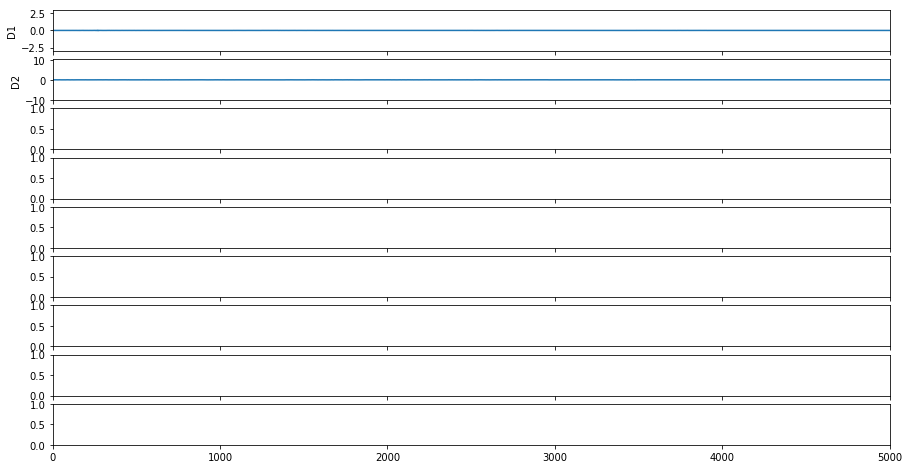

In [10]:

f, axarr = plt.subplots(9, sharex=True,figsize=(15,8))
axarr[0].axis([0,5000,-3,3])
axarr[0].plot(D1)
axarr[0].set_ylabel('D1')
axarr[1].plot(D2)
axarr[1].set_ylabel('D2')
axarr[2].plot(D3)
axarr[2].set_ylabel('D3')
axarr[3].plot(D4)
axarr[3].set_ylabel('D4')
axarr[4].plot(D5)
axarr[4].set_ylabel('D5')
axarr[5].plot(D6)
axarr[5].set_ylabel('D6')
axarr[6].plot(D7)
axarr[6].set_ylabel('D7')
axarr[7].plot(A7)
axarr[7].set_ylabel('A7')
axarr[8].plot(ecg)
axarr[8].set_ylabel('ecg')
axarr[8].plot(ecg_rec)

### Plot dei picchi trovati su D2

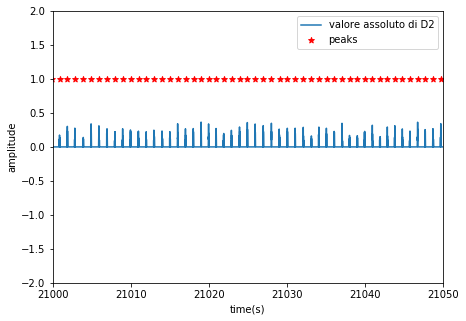

In [58]:
plt.figure(figsize=(7,5))
plt.axis([21000,21050,-2,2])
time_peaks=[i/100 for i in peaks]
peaks_value=[1 for i in peaks]
plt.plot(time_ecg,D2_abs_th)
plt.scatter(time_peaks,peaks_value,marker='*',color='r')
plt.xlabel('time(s)')
plt.ylabel('amplitude')
plt.legend(['valore assoluto di D2','peaks'])

### Plot dei picchi trovati su ECG

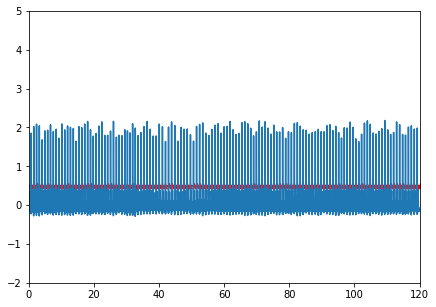

In [71]:
#Riporto i picchi su ecg
plt.figure(figsize=(7,5))
plt.axis([0,120,-2,5])
peaks_value=[0.5 for i in peaks]
time_peaks=[i/100 for i in peaks]
plt.plot(time_ecg,ecg_filtered)
plt.scatter(time_peaks,peaks_value,marker='*',color='r')

In [60]:
prova=[]
for i in range(0,len(time_peaks)-1):
    prova.append(time_peaks[i]-time_peaks[i+1])

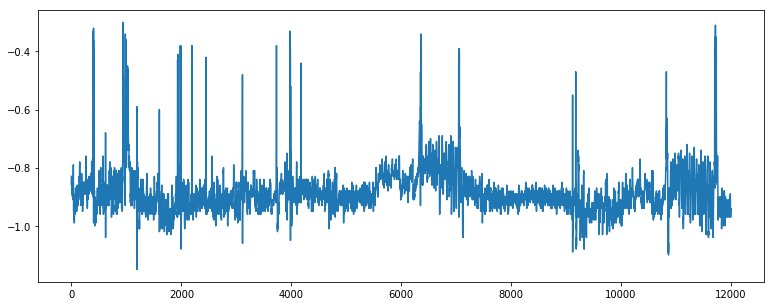

In [73]:
plt.figure(figsize=(13,5))
plt.plot(RR_intervals[0:12000])

### Plot dei picchi corretti su ECG

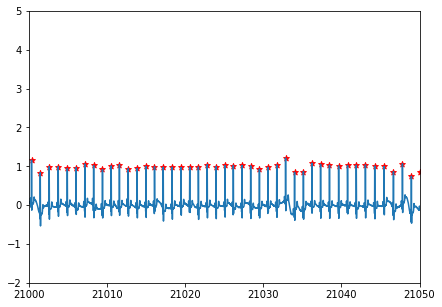

In [34]:
#Riporto i picchi corretti su ecg
plt.figure(figsize=(7,5))
plt.axis([21000,21050,-2,5])
Rpeaks_value=[ecg_rec[i] for i in peaks_corretti]
Rtime_peaks=[i/100 for i in peaks_corretti]
plt.plot(time_ecg,ecg_rec)
plt.scatter(Rtime_peaks,Rpeaks_value,marker='*',color='r')

In [15]:
f = interp1d(time_peaks, EDR,kind='cubic')
#f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(time_peaks[0], time_peaks[len(time_peaks)-1], num=len(time_peaks)*3, endpoint=True)

In [16]:
df_EDR['edr']=EDR_interp
#df_EDR['edr_amplitude']=EDR_amplitude
df_EDR['time']=xnewEDR

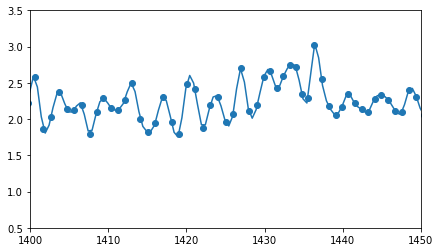

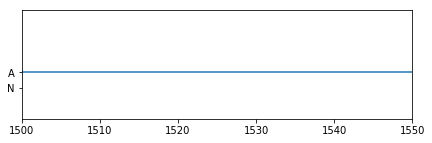

In [19]:
plt.figure(figsize=(7,4))
plt.axis([1400,1450,0.5,3.5])
plt.scatter(time_peaks,EDR_amplitude,marker='o')
plt.plot(xnewEDR,EDR_interp)
plt.figure(figsize=(7,2))
plt.axis([1500,1550,-2,5])
plt.plot(time_apn,apn)

# ESTRAZIONE EDR

## R wave amplitude

# Grafici EDR

### Riporto i punti Q R S su ECG

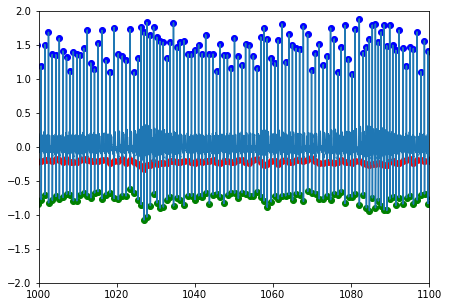

In [77]:
#Riporto i picchi su ecg
plt.figure(figsize=(7,5))
plt.axis([1000,1100,-2,2])
Qpeaks_value=[ecg_rec[i] for i in puntiQ]
Qtime_peaks=[i/100 for i in puntiQ]
Speaks_value=[ecg_rec[i] for i in puntiS]
Stime_peaks=[i/100 for i in puntiS]
plt.plot(time_ecg,ecg_rec)
plt.scatter(Qtime_peaks,Qpeaks_value,marker='o',color='r')
plt.scatter(Stime_peaks,Speaks_value,marker='o',color='g')
plt.scatter(Rtime_peaks,Rpeaks_value,marker='o',color='b')

### Plot di EDR

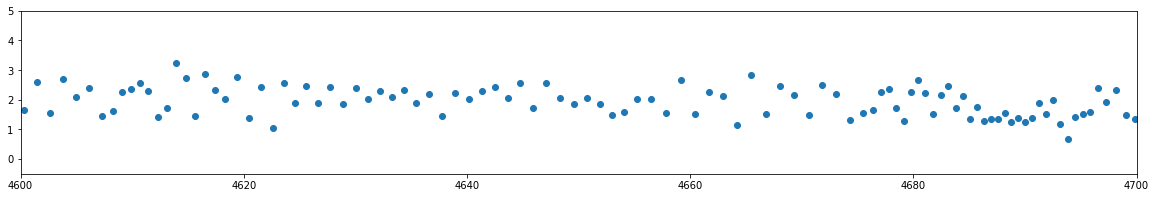

In [100]:
plt.figure(figsize=(20,3))
plt.axis([4600,4700,-0.5,5])
#plt.plot(EDR)
plt.scatter(time_EDR,EDR)

### Plot apnee

In [108]:
dfAPNEA=pd.DataFrame()
ann = wfdb.rdann(recordname, extension="apn")
time_apn=ann.sample/100
apn=ann.symbol


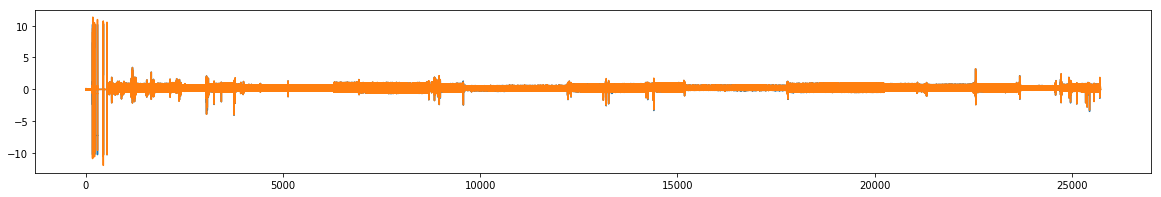

In [160]:
plt.figure(figsize=(20,3))
#plt.axis([0,1500,-2,5])
plt.plot(time_ecg,ecg)
plt.plot(time_ecg,ecg_rec)

In [279]:
import scipy.signal as signal
y = butter_bandpass_filter(ecg, 0.2, 0.4, Fs_ecg, order=1)

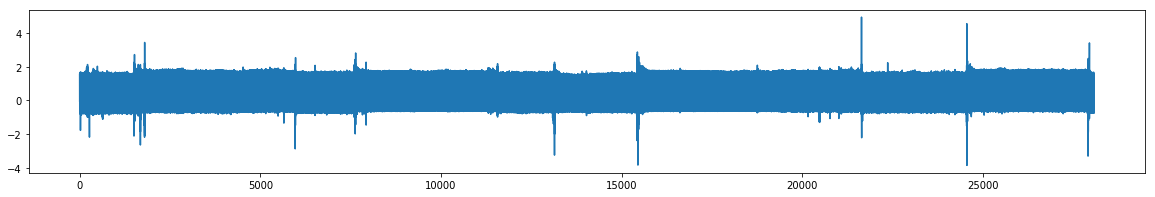

In [153]:
plt.figure(figsize=(20,3))
#plt.axis([30000,30060,-0.5,.5])
plt.plot(time_ecg,ecg_rec)

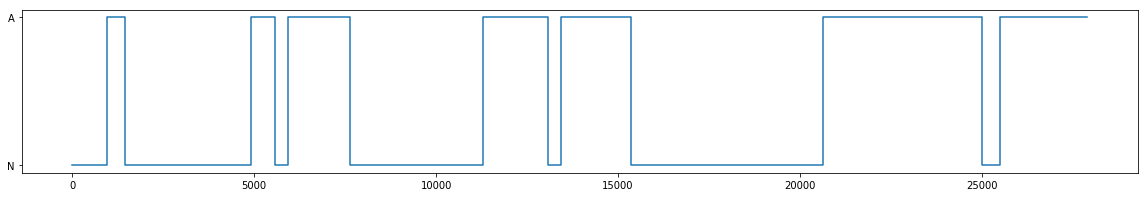

In [150]:
plt.figure(figsize=(20,3))
#plt.axis([800,900,-2,5])
plt.step(time_apn,apn)

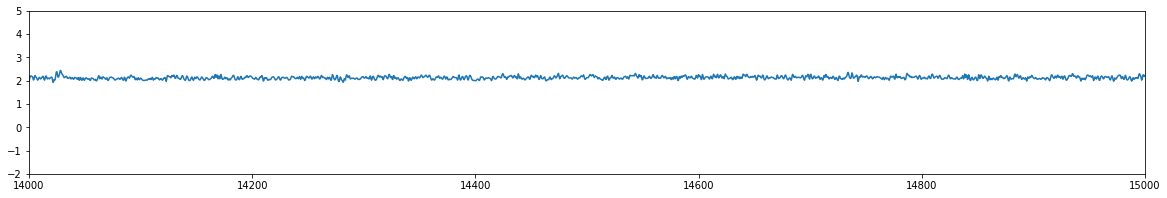

In [151]:
plt.figure(figsize=(20,3))
plt.axis([14000,15000,-2,5])
plt.plot(xnewEDR,EDR_interp)

In [91]:
statistics.variance(EDR_interp[20000*2:21000*2])

0.01616690725380492

In [79]:
xnewEDR[2000]

1000.6637208673002

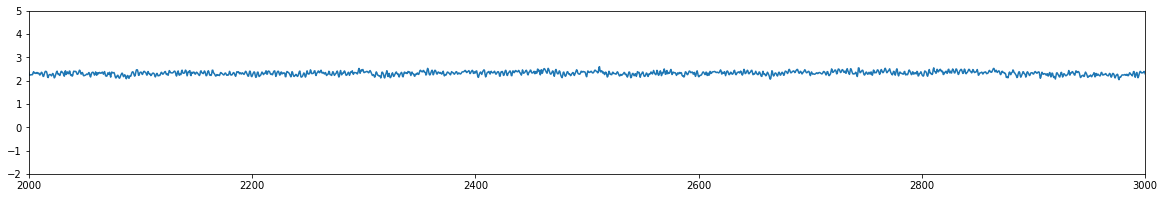

In [152]:
plt.figure(figsize=(20,3))
plt.axis([2000,3000,-2,5])
plt.plot(xnewEDR,EDR_interp)
#plt.plot(time_ecg,ecg)

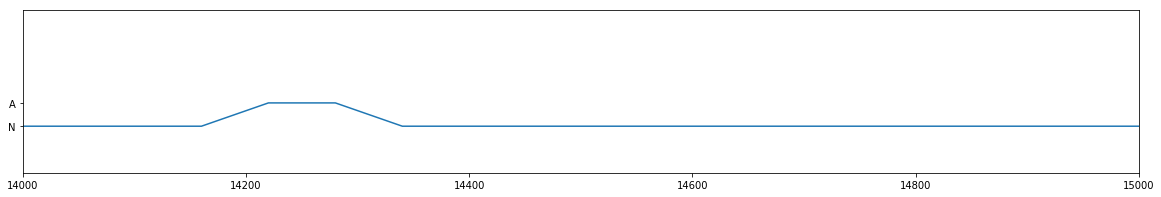

In [139]:
plt.figure(figsize=(20,3))
plt.axis([14000,15000,-2,5])
plt.plot(time_apn,apn)
#plt.plot(time_ecg,ecg)

In [48]:
m=statistics.mean(RR_intervals[0:len(RR_intervals)-1])

In [53]:
for i in range(0,len(RR_intervals)):
    if(RR_intervals[i]>m):
        RR_intervals[i]=m
    if(RR_intervals[i]<-m):
         RR_intervals[i]=-m